Dataset:  https://drive.google.com/drive/folders/1HUCM3OPmKngpeEV5_WZd-_aMcZd4KohW?usp=sharing

This work combines pre-trained CNN models (DenseNet201, InceptionV3, Xception, ResNet50V2) for feature extraction with traditional machine learning classifiers (Random Forest, Decision Tree, MLP). The extracted features are enhanced using data augmentation and gamma correction. Hyperparameter optimization is performed with GridSearchCV, and the models are combined using Voting and Stacking classifiers. The performance is evaluated on validation and test sets, with accuracy and confusion matrix used to assess the final model's effectiveness.

In [ ]:
import os
import numpy as np
import cv2
import timm
from tensorflow.keras.applications import DenseNet201, InceptionV3, Xception, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import adaptive_avg_pool2d
import tensorflow as tf
import matplotlib.pyplot as plt




In [3]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-6
PATIENCE = 2
FACTOR = 0.5
MONITOR = "val_loss"
SAVE_BEST_ONLY = True
MODE = "min"
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = "categorical_crossentropy"

# Paths
data_dir = "./D01"

def apply_gamma_correction(image, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Définition des transformations d'augmentation
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

def load_data_with_augmentation(data_dir, apply_gamma_flag=False, gamma=1.5):
    original_images, preprocessed_images, labels = [], [], []

    for label, class_dir in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue

            img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            original_images.append(img_resized / 255.0)

            preprocessed_img = img_resized.copy()
            if apply_gamma_flag:
                preprocessed_img = apply_gamma_correction(preprocessed_img, gamma)

            preprocessed_images.append(preprocessed_img / 255.0)
            labels.append(label)

    X = np.array(original_images + preprocessed_images)
    y = np.array(labels + labels)

    # Appliquer l'augmentation uniquement sur l'ensemble d'entraînement
    X_augmented, y_augmented = [], []
    for i in range(len(X)):
        img = X[i].reshape((1,) + X[i].shape)
        for _ in range(2):
            augmented_img = next(data_gen.flow(img, batch_size=1))[0]
            X_augmented.append(augmented_img)
            y_augmented.append(y[i])

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    X_combined = np.concatenate((X, X_augmented), axis=0)
    y_combined = np.concatenate((y, y_augmented), axis=0)

    return X_combined, y_combined




In [4]:
# Charger les données avec augmentation
X_combined, y_combined = load_data_with_augmentation(data_dir, apply_gamma_flag=True, gamma=1.5)
y_combined = to_categorical(y_combined)

In [5]:
# Split en train, val et test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [6]:
# Define feature extraction models
def create_model(base_model, input_shape):
    base = base_model(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base.output)
    return Model(inputs=base.input, outputs=x)

input_shape = (224, 224, 3)
model_DenseNet201 = create_model(DenseNet201, input_shape)
model_InceptionV3 = create_model(InceptionV3, input_shape)
model_Xception = create_model(Xception, input_shape)
model_ResNet50V2 = create_model(ResNet50V2, input_shape)



# Feature extraction in batches
def extract_features_in_batches(model, data, batch_size=32):
    features = []
    for start in range(0, len(data), batch_size):
        end = start + batch_size
        batch_data = data[start:end]
        batch_tensor = tf.convert_to_tensor(batch_data, dtype=tf.float32)
        batch_features = model.predict(batch_tensor)  # Updated to use .predict()
        features.append(batch_features)
    return np.vstack(features)


In [7]:
# Extract features for training
features_DenseNet201 = extract_features_in_batches(model_DenseNet201, X_train, batch_size=BATCH_SIZE)
features_InceptionV3 = extract_features_in_batches(model_InceptionV3, X_train, batch_size=BATCH_SIZE)
features_Xception = extract_features_in_batches(model_Xception, X_train, batch_size=BATCH_SIZE)
features_ResNet50V2 = extract_features_in_batches(model_ResNet50V2, X_train, batch_size=BATCH_SIZE)


# Combine extracted features
X_train_features = np.concatenate([features_DenseNet201, features_InceptionV3, features_Xception, features_ResNet50V2], axis=1)

c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1020']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1020']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1153']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1153']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [8]:
# Extract features for validation
features_DenseNet201_val = extract_features_in_batches(model_DenseNet201, X_val, batch_size=BATCH_SIZE)
features_InceptionV3_val = extract_features_in_batches(model_InceptionV3, X_val, batch_size=BATCH_SIZE)
features_Xception_val = extract_features_in_batches(model_Xception, X_val, batch_size=BATCH_SIZE)
features_ResNet50V2_val = extract_features_in_batches(model_ResNet50V2, X_val, batch_size=BATCH_SIZE)


X_val_features = np.concatenate([features_DenseNet201_val, features_InceptionV3_val, features_Xception_val, features_ResNet50V2_val], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━

In [9]:
# Extract features for testing

features_DenseNet201_test = extract_features_in_batches(model_DenseNet201, X_test, batch_size=BATCH_SIZE)
features_InceptionV3_test = extract_features_in_batches(model_InceptionV3, X_test, batch_size=BATCH_SIZE)
features_Xception_test = extract_features_in_batches(model_Xception, X_test, batch_size=BATCH_SIZE)
features_ResNet50V2_test = extract_features_in_batches(model_ResNet50V2, X_test, batch_size=BATCH_SIZE)


X_test_features = np.concatenate([features_DenseNet201_test, features_InceptionV3_test, features_Xception_test, features_ResNet50V2_test], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━

In [10]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# 1️⃣ Définir les hyperparamètres à tester pour chaque modèle
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_features": ["sqrt", "log2"],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 5, 10]
}

dt_params = {
    "max_depth": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 2, 5]
}

mlp_params = {
    "hidden_layer_sizes": [(50,), (100, 50), (100,)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate": ["constant", "adaptive"]
}


In [11]:

# 2️⃣ Recherche des meilleurs hyperparamètres avec GridSearchCV
print("Optimisation du RandomForest...")
rf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state=1), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train_features, np.argmax(y_train, axis=1))
best_rf = rf.best_estimator_
print("Meilleurs paramètres RF:", rf.best_params_)



Optimisation du RandomForest...
Meilleurs paramètres RF: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
print("Optimisation du DecisionTree...")
dt = GridSearchCV(DecisionTreeClassifier(class_weight="balanced", random_state=0), dt_params, cv=3, n_jobs=-1)
dt.fit(X_train_features, np.argmax(y_train, axis=1))
best_dt = dt.best_estimator_
print("Meilleurs paramètres DT:", dt.best_params_)


Optimisation du DecisionTree...
Meilleurs paramètres DT: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1}


In [13]:
print("Optimisation du MLP...")
mlp = GridSearchCV(MLPClassifier(max_iter=600, random_state=42), mlp_params, cv=3, n_jobs=-1)
mlp.fit(X_train_features, np.argmax(y_train, axis=1))
best_mlp = mlp.best_estimator_
print("Meilleurs paramètres MLP:", mlp.best_params_)


Optimisation du MLP...
Meilleurs paramètres MLP: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}


In [14]:
ensemble_model = VotingClassifier(estimators=[("RF", best_rf), ("DT", best_dt), ("MLP", best_mlp)], voting="hard",
                                   weights=[1, 2, 3], n_jobs=-1, verbose=2, flatten_transform=True)

# Entraîner le modèle
ensemble_model.fit(X_train_features, np.argmax(y_train, axis=1))


VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight='balanced',
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     random_state=1)),
                             ('DT',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=50,
                                                     random_state=0)),
                             ('MLP',
                              MLPClassifier(hidden_layer_sizes=(50,),
                                            max_iter=600, random_state=42))],
                 n_jobs=-1, verbose=2, weights=[1, 2, 3])

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
stacking_model = StackingClassifier(estimators=[("RF", best_rf), ("DT", best_dt), ("MLP", best_mlp)], final_estimator=meta_model,
                                     passthrough=True, n_jobs=-1)

# Entraîner le modèle de stacking
stacking_model.fit(X_train_features, np.argmax(y_train, axis=1))


StackingClassifier(estimators=[('RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       random_state=1)),
                               ('DT',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=50,
                                                       random_state=0)),
                               ('MLP',
                                MLPClassifier(hidden_layer_sizes=(50,),
                                              max_iter=600, random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

In [17]:
# Validate ensemble model
y_val_pred = stacking_model.predict(X_val_features)

val_acc = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {val_acc}")


Validation Accuracy: 0.9781121751025992


In [18]:
# Test ensemble model
y_test_pred = stacking_model.predict(X_test_features)
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

# Calculate test accuracy
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       362
           1       0.97      0.98      0.97       369

    accuracy                           0.97       731
   macro avg       0.97      0.97      0.97       731
weighted avg       0.97      0.97      0.97       731

Test Accuracy: 0.9740082079343365


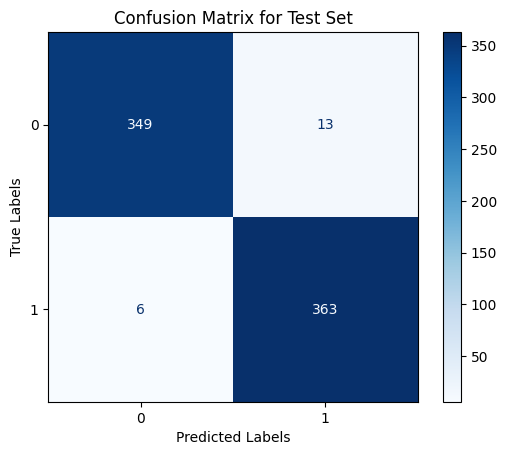

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(np.argmax(y_test, axis=1)))
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix for Test Set")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()


